In [1]:
import numpy as np
from polara import RecommenderData
from polara import RecommenderModel
from polara import get_movielens_data

%matplotlib inline

# Get Movielens-1M data

this will download movielens-1m dataset from http://grouplens.org/datasets/movielens/:

In [2]:
data, genres = get_movielens_data('c:/Users/evfro/Downloads/ml-1m.zip', get_genres=True, split_genres=False)

In [3]:
data.head()

,userid,movieid,rating
0,1,1193,5
1,1,661,3
2,1,914,3
3,1,3408,4
4,1,2355,5


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000209 entries, 0 to 1000208
Data columns (total 3 columns):
userid     1000209 non-null int64
movieid    1000209 non-null int64
rating     1000209 non-null int64
dtypes: int64(3)
memory usage: 22.9 MB


In [5]:
genres.head()

,movieid,movienm,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


Rating distribution in the dataset:

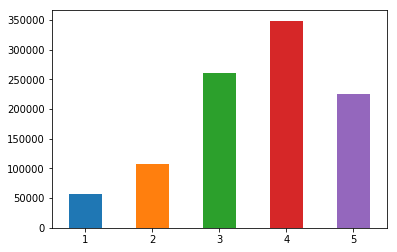

In [6]:
data.rating.value_counts().sort_index().plot.bar(rot=0)

# Building our first recommender model

## Preparing data

`RecommenderData` class provides a set of tools for manipulating the data and preparing it for experimentation.
Input parameters are: the data itself (pandas dataframe) and mapping of the data fields (column names) to internal representation: `userid`, `itemid` and `feedback`:

In [7]:
data_model = RecommenderData(data, userid='userid', itemid='movieid', feedback='rating', seed=0)

Verify correct mapping:

In [8]:
data_model.fields

Fields(userid='userid', itemid='movieid', feedback='rating')

`RecommenderData` class has a number of parameters to control how the data is processed. Defaults are fine to start with:

In [9]:
data_model.get_configuration()

{'test_ratio': 0.2,
 'test_fold': 5,
 'negative_prediction': False,
 'random_holdout': False,
 'shuffle_data': False,
 'permute_tops': False,
 'test_sample': None,
 'holdout_size': 3,
 'warm_start': True}

Let's focus on standard evaluation scenario:

In [10]:
data_model.warm_start = False

Use `prepare` method to split the dataset into 2 parts: training data and test data.

In [11]:
data_model.prepare()

Preparing data...
1 unique movieid's within 1 holdout interactions were filtered. Reason: not in the training data.
1 of 1208 userid's were filtered out from holdout. Reason: incompatible number of items.
Done.
There are 996585 events in the training and 3621 events in the holdout.


As the original data possibly contains gaps in users' and items' indices, the data preparation process will clean this up: items from the training data will be indexed starting from zero with no gaps and the result will be stored in:

In [12]:
data_model.index.itemid.head()

,old,new
0,1,0
1,2,1
2,3,2
3,4,3
4,5,4


Similarly, all userid's from both training and test set are reindexed and stored in:

In [13]:
data_model.index.userid.training.head()

,old,new
0,1,0
1,2,1
2,3,2
3,4,3
4,5,4


Internally only new inices are used. This ensures consistency of various methods used by the model.

The dataset is split according to `test_fold` and `test_ratio` attributes. By default it uses first 80% of users for training and last 20% of the users as test data.

In [14]:
data_model.training.head()

,userid,movieid,rating
0,0,1104,5
1,0,639,3
2,0,853,3
3,0,3176,4
4,0,2162,5


In [15]:
data_model.training.shape

(996585, 3)

In the `warm_start` regime the test data is further split into `testset` and evaluation set (`evalset`). Testset is used to generate recommendations, which are than evaluated against the evaluation set.

However, in standard scenario the `testset` is simply a part og the training data and is never stored explicitly. If you really need it, it can be generated on the fly with the `_recover_testset` method:

In [16]:
testset = data_model._recover_testset()
testset.head()

,userid,movieid,rating
807458,4832,579,5
807514,4832,1275,3
807513,4832,1236,3
807512,4832,2494,4
807511,4832,3374,2


In [17]:
testset.shape

(189075, 3)

The `holdout` can be always accessed directly: 

In [18]:
data_model.test.holdout.head(10)

,userid,movieid,rating
807537,4832,1833,5
807534,4832,971,5
807532,4832,2557,5
807805,4833,527,5
807802,4833,1838,5
807756,4833,2159,5
807899,4834,1848,5
807893,4834,2557,5
807872,4834,2103,5
807964,4835,1845,5


In [19]:
data_model.test.holdout.shape

(3621, 3)

The users in the test and evaluation sets are the same (but this users are not in the `training` set!).
For every test user the evaluation set contains a fixed number of items which are held out from the original test data. The number of holdout items is controlled by `holdout_size` parameter. By default it's set to 3:

In [20]:
data_model.holdout_size

3

In [21]:
(data_model.test.holdout.groupby('userid').movieid.count() == data_model.holdout_size).all()

True

In [22]:
data_model.test.holdout.to_csv('holdout.csv', index=False)

## Creating recommender model

You can create your own model by subclassing `RecommenderModel` class and defining two required methods:  `self.build()`  and  `self.get_recommendations()`:

In [31]:
class TopMovies(RecommenderModel):
    def build(self):
        itemid = self.data.fields.itemid # get the name of the column, that corresponds to movieid
        # calculate popularity of the movies based on the number of ratings
        item_scores = self.data.training[itemid].value_counts(normalize=True).sort_index()
        # store it for later use in some attribute
        self.item_scores = item_scores.values
        
        
    def get_recommendations(self):
        userid = self.data.fields.userid #get the name of the column, that corresponds to userid
        
        # get the number of test users
        num_users = self.data.test.holdout[userid].nunique()
        
        # repeat computed popularity scores in accordance with the number of test users
        scores = np.repeat(self.item_scores[None, :], num_users, axis=0)
        if self.filter_seen:
            #prevent seen items from appearing in recommendations
            itemid = self.data.fields.itemid
            test_data, _, _ = self._get_test_data()
            self.downvote_seen_items(scores, test_data)
        # we've got scores, but what we actually need is items (their id's)
        # we also need only top-k items, not all of them (for top-k recommendation task)
        # here's how to get it:
        top_recs = self.get_topk_elements(scores)
        # the leftmost items in this array are those with the highest scores
        return top_recs

### generating recommendations:

In [41]:
top = TopMovies(data_model) # the model takes as input parameter the recommender data model

In [42]:
top.build()

In [46]:
top.switch_positive = None

In [39]:
top.evaluate()

Hits(true_positive=432, false_positive=11638, true_negative=None, false_negative=3189)

Note, that recommendations, generated by this model, do not take into account the fact, that some of the recommended items may be present in the test set and thus, should not be recommended (they are considered seen by a test user). In order to fix that you can use `filter_seen` parameter along with `downvote_seen_items` method as follows:

```python
if self.filter_seen:
    #prevent seen items from appearing in recommendations
    itemid = self.data.fields.itemid
    test_data, _, _ = self._get_test_data()
    self.downvote_seen_items(scores, test_data)
```
With this procedure "seen" items will get the lowest scores and they will be sorted out. Place this code snippet inside the `get_recommendations` routine before handovering scores into `get_topk_elements`. This will improve the baseline.

## Task

Make the corresponding modifications and check how the result is changed.

### Alternative way

Another way is to define `slice_recommendations` instead of `get_recommendations` method. With `slice_recommendations` defined, the model will scale better when huge datasets are used. Moreover, it automatically takes care of seen items.

The method `slice_recommendations` takes a piece of the test data slice by slice instead of processing it as a whole. Slice if defined by `start` and `stop` parameter (which are simply a userid to start with and userid to stop at). Slicing the data avoids memory overhead and leads to a faster evaluation of models. Slicing is done automatically behind the scene and you don't have to specify anything else. Another advantage: seen items will be automatically sorted out from recommendations as long as `filter_seen` attribute is set to `True` (it is by default). So it requires less lines of code.

In [47]:
 class TopMoviesALT(RecommenderModel):
    def build(self):
        # should be the same as in TopMovies
        
    def slice_recommendations(self, test_data, shape, start, stop, test_users=None):
        # current implementation requires handovering slice data in specific format further,
        # and the easiest way to get it is via get_test_matrix method. It also returns
        # test data in sparse matrix format, but as our recommender model is non-personalized
        # we don't actually need it. See SVDModel implementation to see when it's useful.
        test_matrix, slice_data = self.get_test_matrix(test_data, shape, (start, stop))
        nusers = stop - start
        scores = np.repeat(self.item_scores[None, :], nusers, axis=0)
        return scores, slice_data

Now everything is set to create an instance of the recommender model and produce recommendations.

In [50]:
top = TopMoviesALT(data_model) # the model takes as input parameter the recommender data model

In [51]:
top.build()

In [52]:
recs = top.get_recommendations()

In [53]:
top.topk

10

You can evaluate your model befotre submitting the results (to ensure that you have improved above baseline):

In [54]:
top.evaluate()

Hits(true_positive=432, false_positive=11638, true_negative=None, false_negative=3189)

## What is recommended?

Let's see what are the most poular movies

In [55]:
# get internal indices of top-10 movies
top_ids = np.argsort(-top.item_scores)[:10]

# convert internal indices into external movie ids
top_movies = data_model.index.itemid.set_index('new').loc[top_ids, 'old'].values

See top movies information:

In [56]:
genres.set_index('movieid').loc[top_movies]

,movienm,genres
movieid,,
2858,American Beauty (1999),Comedy|Drama
1196,Star Wars: Episode V - The Empire Strikes Back...,Action|Adventure|Drama|Sci-Fi|War
260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Fantasy|Sci-Fi
1210,Star Wars: Episode VI - Return of the Jedi (1983),Action|Adventure|Romance|Sci-Fi|War
480,Jurassic Park (1993),Action|Adventure|Sci-Fi
589,Terminator 2: Judgment Day (1991),Action|Sci-Fi|Thriller
2571,"Matrix, The (1999)",Action|Sci-Fi|Thriller
1270,Back to the Future (1985),Comedy|Sci-Fi
593,"Silence of the Lambs, The (1991)",Drama|Thriller


## Task

Try to change your model to maximize the `true_positive` score.

# Submitting model predictions

### submitting your model:

After you have created your perfect recsys model, firstly, save your recommendation into file. Please, use your name as the name for file (this will be used to display at leaderboard)

In [63]:
np.savez('!popularity_baseline', recs=recs)

Now you can uppload your results:

In [64]:
import requests

files = {'upload': open('!popularity_baseline.npz','rb')}
url = "http://recsysvalley.azurewebsites.net/upload"

r = requests.post(url, files=files)

Verify, that upload is successful:

In [65]:
print(r.status_code, r.reason)

200 OK


You can also do it manyally at http://recsysvalley.azurewebsites.net/upload

Check out how do your result compare to others at: http://recsysvalley.azurewebsites.net/leaderboard